In [134]:
import pandas as pd
import numpy as np
data = pd.read_csv(r"C:\Users\sarthak sanwal\ML_algo_trading\HDBK Historical Data_2.csv")
data_2 = data.drop(['Date'], axis = 1)
data_3 = data_2.loc[::-1]
df = data_3.reset_index(drop = True)
df.head()

,Open,High,Low,Close,Volume,Change %
0,21.94,21.94,21.45,21.51,187.52K,-0.23%
1,21.65,21.85,21.44,21.79,315.39K,1.30%
2,21.51,21.8,21.45,21.5,342.11K,-1.33%
3,21.49,21.55,21.36,21.44,909.09K,-0.28%
4,21.45,21.75,21.41,21.72,889.01K,1.31%


In [135]:
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Change %    0
dtype: int64

In [136]:
df['High'] = df['High'].replace('[^\d.]', '', regex=True)
df['High'] = df['High'].astype(float)
df['Close'] = df['Close'].replace('[^\d.]', '', regex=True)
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].replace('[^\d.]', '', regex=True)
df['Open'] = df['Open'].astype(float)
df['Low'] = df['Low'].replace('[^\d.]', '', regex=True)
df['Low'] = df['Low'].astype(float)

In [137]:
df['High']

0         21.94
1         21.85
2         21.80
3         21.55
4         21.75
         ...   
4995    1664.90
4996    1668.20
4997    1661.65
4998    1658.50
4999    1661.75
Name: High, Length: 5000, dtype: float64

In [138]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.Low[i]>df1.Low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.Low[i]<df1.Low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.High[i]<df1.High[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.High[i]>df1.High[i-1]):
            return 0
    return 1

In [192]:
length = len(df)
High = list(df['High'])
Low = list(df['Low'])
Close = list(df['Close'])
Open = list(df['Open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(Open[row]-Close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 5
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        Open[row-1]<Close[row-1] and
        Open[row]>Close[row] and 
        (Open[row]-Close[row-1])>=0 and Close[row]<Open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        Open[row-1]>Close[row-1] and
        Open[row]<Close[row] and 
        (Open[row]-Close[row-1])<=0 and Close[row]>Open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 5
    row=l
    highdiff[row] = high[row]-max(Open[row],Close[row])
    lowdiff[row] = min(Open[row],Close[row])-low[row]
    bodydiff[row] = abs(Open[row]-Close[row])
    if bodydiff[row]<1:
        bodydiff[row]=1
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.High[l]-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c2 = abs(max(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c3 = min(df.Open[l],df.Close[l])<min(levels, key=lambda x:abs(x-df.High[l]))
    c4 = df.Low[l]<min(levels, key=lambda x:abs(x-df.High[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.Low[l]-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c2 = abs(min(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c3 = max(df.Open[l],df.Close[l])>min(levels, key=lambda x:abs(x-df.Low[l]))
    c4 = df.High[l]>min(levels, key=lambda x:abs(x-df.Low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [193]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 0) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 0)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0


In [194]:
df['signal']=signal

In [195]:
df[df['signal']==1].count()

Open        30
High        30
Low         30
Close       30
Volume      30
Change %    30
signal      30
dtype: int64

In [196]:
df

,Open,High,Low,Close,Volume,Change %,signal
0,21.94,21.94,21.45,21.51,187.52K,-0.23%,0
1,21.65,21.85,21.44,21.79,315.39K,1.30%,0
2,21.51,21.80,21.45,21.50,342.11K,-1.33%,0
3,21.49,21.55,21.36,21.44,909.09K,-0.28%,0
4,21.45,21.75,21.41,21.72,889.01K,1.31%,0
...,...,...,...,...,...,...,...
4995,1659.40,1664.90,1632.60,1654.20,5.13M,0.15%,0
4996,1654.25,1668.20,1650.00,1654.00,4.22M,-0.01%,0
4997,1660.00,1661.65,1635.55,1650.55,5.89M,-0.21%,0
4998,1648.80,1658.50,1642.20,1657.10,4.09M,0.40%,0


In [197]:
def SIGNAL():
    return df.signal

In [198]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 10
            tp1 = self.data.Close[-1] + 10
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 10
            tp1 = self.data.Close[-1] - 10
            self.sell(sl=sl1, tp=tp1)

In [205]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat

C:\Users\sarthak sanwal\AppData\Local\Temp\ipykernel_23972\3960154592.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                    4999.0
Duration                               4999.0
Exposure Time [%]                       10.38
Equity Final [$]                     19344.06
Equity Peak [$]                      19530.66
Return [%]                            93.4406
Buy & Hold Return [%]             7609.669921
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -27.681111
Avg. Drawdown [%]                   -3.516343
Max. Drawdown Duration                  755.0
Avg. Drawdown Duration             128.541667
# Trades                                125.0
Win Rate [%]                             57.6
Best Trade [%]                        9.10002
Worst Trade [%]                    -14.761396
Avg. Trade [%]                    

In [206]:
bt.plot()

GridPlot(id='p15085', ...)

In [220]:
pipdiff = 30 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

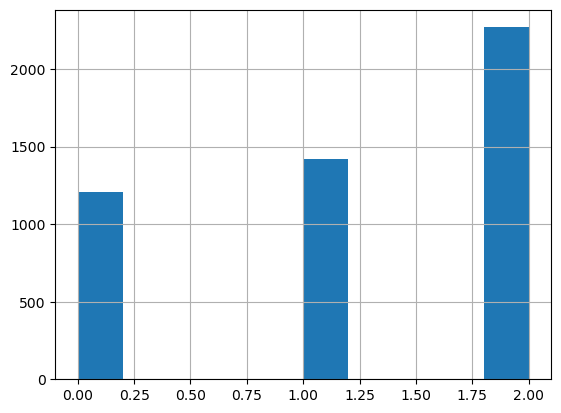

In [223]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(100, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [224]:
 import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Open,High,Low,Close,Volume,Change %,signal,Target,RSI
4980,1615.00,1621.30,1580.30,1585.30,7.37M,-0.96%,0,NaN,44.685640
4981,1589.80,1611.00,1577.50,1608.90,5.39M,1.49%,2,NaN,51.076039
4982,1605.00,1641.60,1599.70,1637.30,9.55M,1.77%,0,NaN,57.394241
4983,1637.00,1650.00,1633.00,1644.10,5.59M,0.42%,0,NaN,58.754639
4984,1644.10,1669.00,1643.40,1660.95,9.42M,1.02%,0,NaN,61.964641
4985,1666.25,1682.60,1661.40,1673.10,7.72M,0.73%,0,NaN,64.112838
4986,1675.05,1702.40,1675.00,1695.50,12.49M,1.34%,0,NaN,67.700289
4987,1691.40,1692.95,1645.30,1648.65,7.35M,-2.76%,0,NaN,55.355170
4988,1632.00,1637.00,1589.95,1615.80,17.59M,-1.99%,0,NaN,48.711733
4989,1595.00,1625.30,1582.00,1614.15,9.26M,-0.10%,2,NaN,48.400517


In [225]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

              Open         High          Low        Close       signal  \
count  4882.000000  4882.000000  4882.000000  4882.000000  4882.000000   
mean    495.511555   500.500391   490.045633   495.413060     0.041991   
std     470.017059   474.149378   465.478433   469.850369     0.276214   
min      22.150000    23.120000    20.450000    22.640000     0.000000   
25%     109.537500   111.550000   107.275000   109.490000     0.000000   
50%     308.140000   311.310000   302.680000   307.855000     0.000000   
75%     893.680000   902.362500   882.600000   894.080000     0.000000   
max    1705.000000  1725.000000  1671.000000  1688.700000     2.000000   

            Target          RSI  
count  4882.000000  4882.000000  
mean      1.220811    54.244053  
std       0.812468    10.520403  
min       0.000000    15.327775  
25%       1.000000    46.897311  
50%       1.000000    54.482544  
75%       2.000000    61.537389  
max       2.000000    84.935653  


In [226]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,76.747001,0.0,1,0,0
1,77.635313,0.0,1,0,0
2,78.008696,0.0,1,0,0
3,64.273529,0.0,1,0,0
4,59.436333,0.0,1,0,0
...,...,...,...,...,...
4877,58.891038,2.0,1,0,0
4878,63.048397,2.0,1,0,0
4879,65.968354,1.0,1,0,0
4880,63.243011,1.0,1,0,0


In [228]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.8 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 64.3790%
****Test Results****
Accuracy: 41.0440%


In [229]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[ 585   39  563]
 [ 136  255  529]
 [  94   30 1674]]
[[  0   0   4]
 [ 96  44 362]
 [ 72  42 357]]
              precision    recall  f1-score   support

         0.0       0.72      0.49      0.58      1187
         1.0       0.79      0.28      0.41       920
         2.0       0.61      0.93      0.73      1798

    accuracy                           0.64      3905
   macro avg       0.70      0.57      0.58      3905
weighted avg       0.68      0.64      0.61      3905

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.51      0.09      0.15       502
         2.0       0.49      0.76      0.60       471

    accuracy                           0.41       977
   macro avg       0.34      0.28      0.25       977
weighted avg       0.50      0.41      0.37       977

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


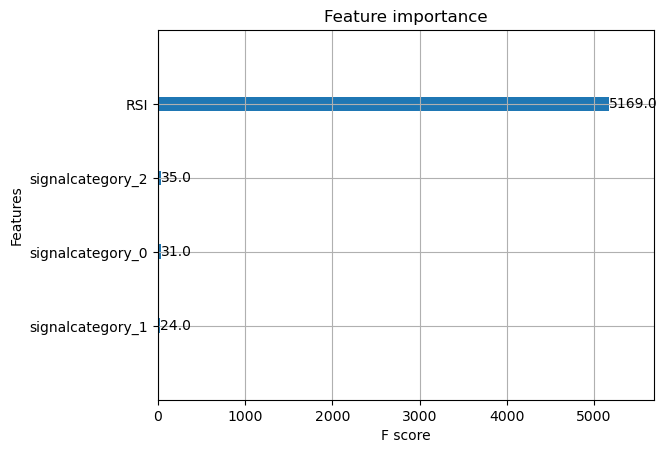

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [230]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [235]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 46.0278%
****Test Results****
Accuracy: 50.5112%


In [236]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[   0    0 1191]
 [   0    0 1180]
 [   0    0 2022]]
[[  0 242]
 [  0 247]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1191
         1.0       0.00      0.00      0.00      1180
         2.0       0.46      1.00      0.63      2022

    accuracy                           0.46      4393
   macro avg       0.15      0.33      0.21      4393
weighted avg       0.21      0.46      0.29      4393

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       242
         2.0       0.51      1.00      0.67       247

    accuracy                           0.51       489
   macro avg       0.25      0.50      0.34       489
weighted avg       0.26      0.51      0.34       489



C:\Users\sarthak sanwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarthak sanwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarthak sanwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarthak sanwal\Anac